In [1]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cpu


In [3]:
transform = transforms.Compose(
                               [transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

In [4]:
# Load Train, Validation, Test datasets
train_val_dataset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [50000, 10000])
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [5]:
# Size of each datset
print(len(train_val_dataset),len(train_dataset), len(val_dataset), len(test_dataset))

60000 50000 10000 10000


In [6]:
# Define train, val, and test dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=False, num_workers=2)

val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

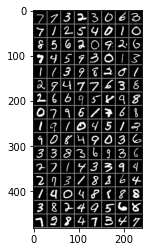

In [7]:
# Showing a part of dataset

# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_dataloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
#print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [8]:
# Define a network
model = nn.Sequential(nn.Linear(784, 512),
                     nn.ReLU(),
                     nn.Linear(512, 10),
                     nn.LogSoftmax(dim=1))
model.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=10, bias=True)
  (3): LogSoftmax()
)

In [9]:
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=10, bias=True)
  (3): LogSoftmax()
)


In [10]:
criterion = nn.NLLLoss() # For categorical_cross_entropy, we use LogSoftmax layer with -ve Log Likelihood Loss.
optimizer = optim.RMSprop(model.parameters())

In [11]:
# Training Model along with validation set.
epochs = 5
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
print("Training Started!")
for epoch in range(epochs):
    print("<<====== Training epoch {} ======>>".format(epoch))
    train_loss = 0
    val_loss = 0
    #batch_iter = 0
    train_total = 0
    train_correct = 0
    val_total = 0
    val_correct = 0
    
    # Model Training
    for images, labels in train_dataloader:
        images = images.view(images.shape[0], -1)
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        model.train()
        pred_train = model(images)
        loss = criterion(pred_train, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        _, predicted = torch.max(pred_train.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        #if batch_iter % 10 == 0:
        #    print("Training batch {}".format(batch_iter*128))
            
        #batch_iter+=1
    # Model Validation
    with torch.no_grad():
        for images_val, labels_val in val_dataloader:
            images_val = images_val.view(images_val.shape[0], -1)
            images_val = images_val.to(device)
            labels_val = labels_val.to(device)
            
            model.eval()
            pred_val = model(images_val)
            loss_val = criterion(pred_val, labels_val)
            val_loss += loss_val.item()
            
            _, predicted = torch.max(pred_val.data, 1)
            val_total += labels_val.size(0)
            val_correct += (predicted == labels_val).sum().item()
            
    train_acc = (train_correct/train_total)*100
    train_accuracies.append(train_acc)
    val_acc = (val_correct/val_total)*100
    val_accuracies.append(val_acc)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print("Training Loss for epoch {}: {}".format(epoch, train_loss))
    print("Training Accuracy for epoch {}: {}".format(epoch, train_acc))
    print("Validation Loss for epoch {}: {}".format(epoch, val_loss))
    print("Validation Accuracy for epoch {}: {}".format(epoch, val_acc))
    print("<<===================================>>")
print("Training Complete")

Training Started!
<<====== Training epoch 0 ======>>
Training Loss for epoch 0: 2838.396275192499
Training Accuracy for epoch 0: 85.832
Validation Loss for epoch 0: 37.2883829139173
Validation Accuracy for epoch 0: 85.58
<<===================================>>
<<====== Training epoch 1 ======>>
Training Loss for epoch 1: 140.54199077934027
Training Accuracy for epoch 1: 90.116
Validation Loss for epoch 1: 22.500353254377842
Validation Accuracy for epoch 1: 91.7
<<===================================>>
<<====== Training epoch 2 ======>>
Training Loss for epoch 2: 141.57407402992249
Training Accuracy for epoch 2: 91.38199999999999
Validation Loss for epoch 2: 21.993813702836633
Validation Accuracy for epoch 2: 92.21000000000001
<<===================================>>
<<====== Training epoch 3 ======>>
Training Loss for epoch 3: 119.9128676764667
Training Accuracy for epoch 3: 92.774
Validation Loss for epoch 3: 28.455646718852222
Validation Accuracy for epoch 3: 90.93
<<==================

In [12]:
# Testing Model
test_total = 0
test_correct = 0
test_loss = 0

with torch.no_grad():
        for images_test, labels_test in test_dataloader:
            images_test = images_test.view(images_test.shape[0], -1)
            images_test = images_test.to(device)
            labels_test = labels_test.to(device)
            
            model.eval()
            pred_test = model(images_test)
            loss_test = criterion(pred_test, labels_test)
            test_loss += loss_test.item()
            
            _, predicted = torch.max(pred_test.data, 1)
            test_total += labels_test.size(0)
            test_correct += (predicted == labels_test).sum().item()

test_acc = (test_correct/test_total)*100
print("Test Loss: {}".format(test_loss))
print("Test Accuracy: {}".format(test_acc))

Test Loss: 17.199673981347587
Test Accuracy: 93.86


In [13]:
# Saving Model

torch.save(model.state_dict(), './my_mnist_model.pt') # It is recommended to save state_dict instead of saving the whole model.

# Loading Model

#model.load_state_dict(torch.load('./my_mnist_model.pt', map_location=torch.device('cpu')))

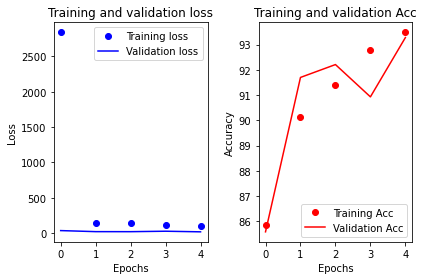

In [14]:
# Plotting training and validation loss and accuracy

epoch_list = [i for i in range(epochs)]
plt.subplot(1,2,1)
plt.plot(epoch_list, train_losses, 'bo', label='Training loss') 
plt.plot(epoch_list, val_losses, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.xlabel('Epochs')
plt.ylabel('Loss') 
plt.legend()

plt.subplot(1,2,2)
plt.plot(epoch_list, train_accuracies, 'ro', label='Training Acc') 
plt.plot(epoch_list, val_accuracies, 'r', label='Validation Acc') 
plt.title('Training and validation Acc') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy') 
plt.legend()
plt.tight_layout()
plt.show()